In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from typing import Dict

warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")

# Set the default font size
FONT_SIZE = 12
plt.rcParams.update({'font.size': FONT_SIZE})

## 0. Load Data

In [124]:
data = pd.read_csv('../data/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


## 1. Data Analysis: First Sight

### How is the date distribuited?

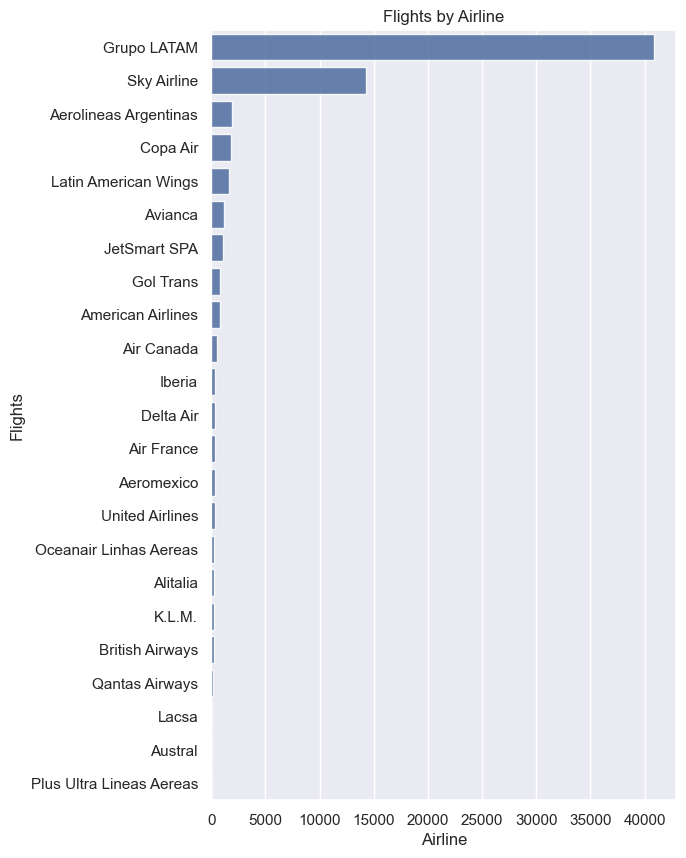

In [125]:
flights_by_airline = data['OPERA'].value_counts()
plt.figure(figsize = (6, 10))

sns.barplot(y=flights_by_airline.index, x=flights_by_airline.values, alpha=0.9)
plt.title('Flights by Airline')
plt.ylabel('Flights')
plt.xlabel('Airline')
plt.show()

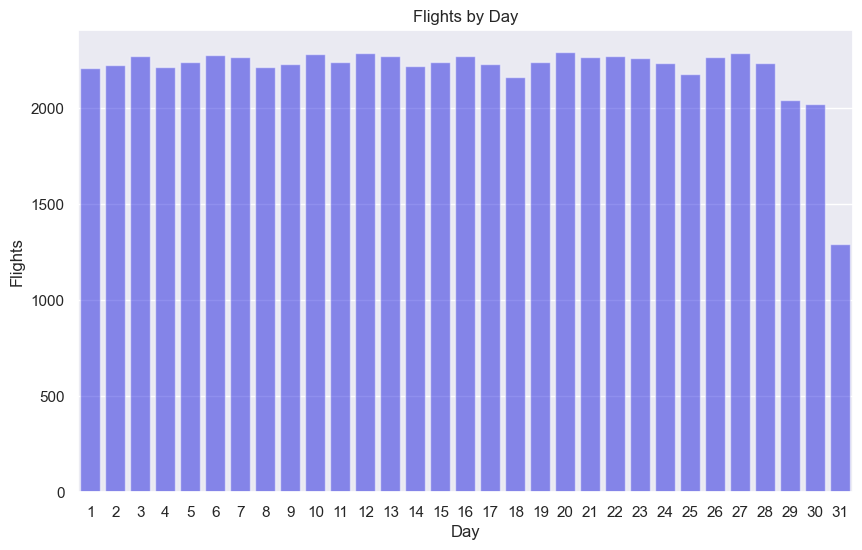

In [126]:
flights_by_day = data['DIA'].value_counts()
plt.figure(figsize = (10, 6))
sns.barplot(x=flights_by_day.index, y=flights_by_day.values, color = 'blue', alpha=0.5)
plt.title('Flights by Day')
plt.ylabel('Flights')
plt.xlabel('Day')
plt.xticks()
plt.show()

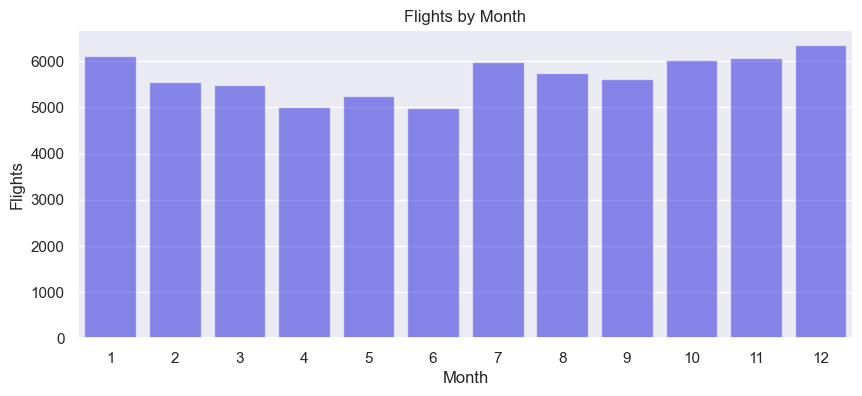

In [127]:
flights_by_month = data['MES'].value_counts()
plt.figure(figsize = (10, 4))
sns.barplot(x=flights_by_month.index, y=flights_by_month.values, color = 'blue', alpha=0.5)
plt.title('Flights by Month')
plt.ylabel('Flights')
plt.xlabel('Month')
plt.xticks(rotation=0)
plt.show()

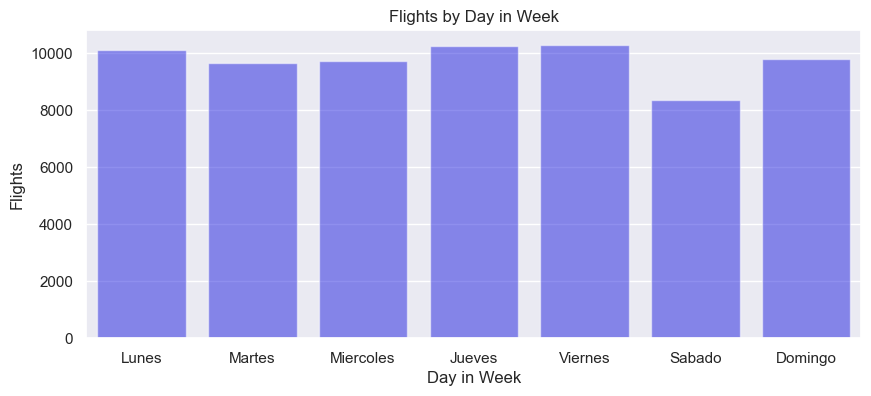

In [256]:
flights_by_day_in_week = data['DIANOM'].value_counts()
days = [
    flights_by_day_in_week.index[2], 
    flights_by_day_in_week.index[5], 
    flights_by_day_in_week.index[4], 
    flights_by_day_in_week.index[1], 
    flights_by_day_in_week.index[0], 
    flights_by_day_in_week.index[6], 
    flights_by_day_in_week.index[3]
]
values_by_day = [
    flights_by_day_in_week.values[2], 
    flights_by_day_in_week.values[5], 
    flights_by_day_in_week.values[4], 
    flights_by_day_in_week.values[1], 
    flights_by_day_in_week.values[0], 
    flights_by_day_in_week.values[6], 
    flights_by_day_in_week.values[3]
]
plt.figure(figsize = (10, 4))

sns.barplot(x=days, y=values_by_day, color = 'blue', alpha=0.5)
plt.title('Flights by Day in Week')
plt.ylabel('Flights')
plt.xlabel('Day in Week')
plt.xticks()
plt.show()

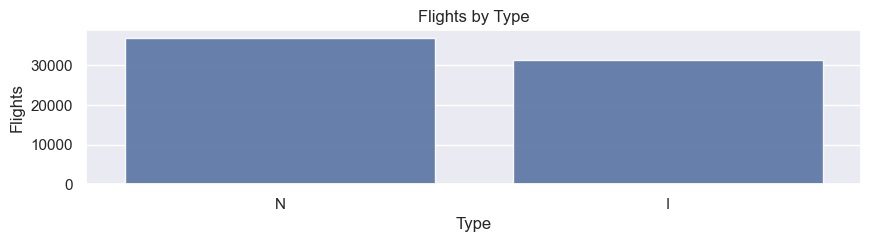

In [129]:
flights_by_type = data['TIPOVUELO'].value_counts()

plt.figure(figsize = (10, 2))
sns.barplot(x=flights_by_type.index, y=flights_by_type.values, alpha=0.9)
plt.title('Flights by Type')
plt.ylabel('Flights')
plt.xlabel('Type')
plt.show()

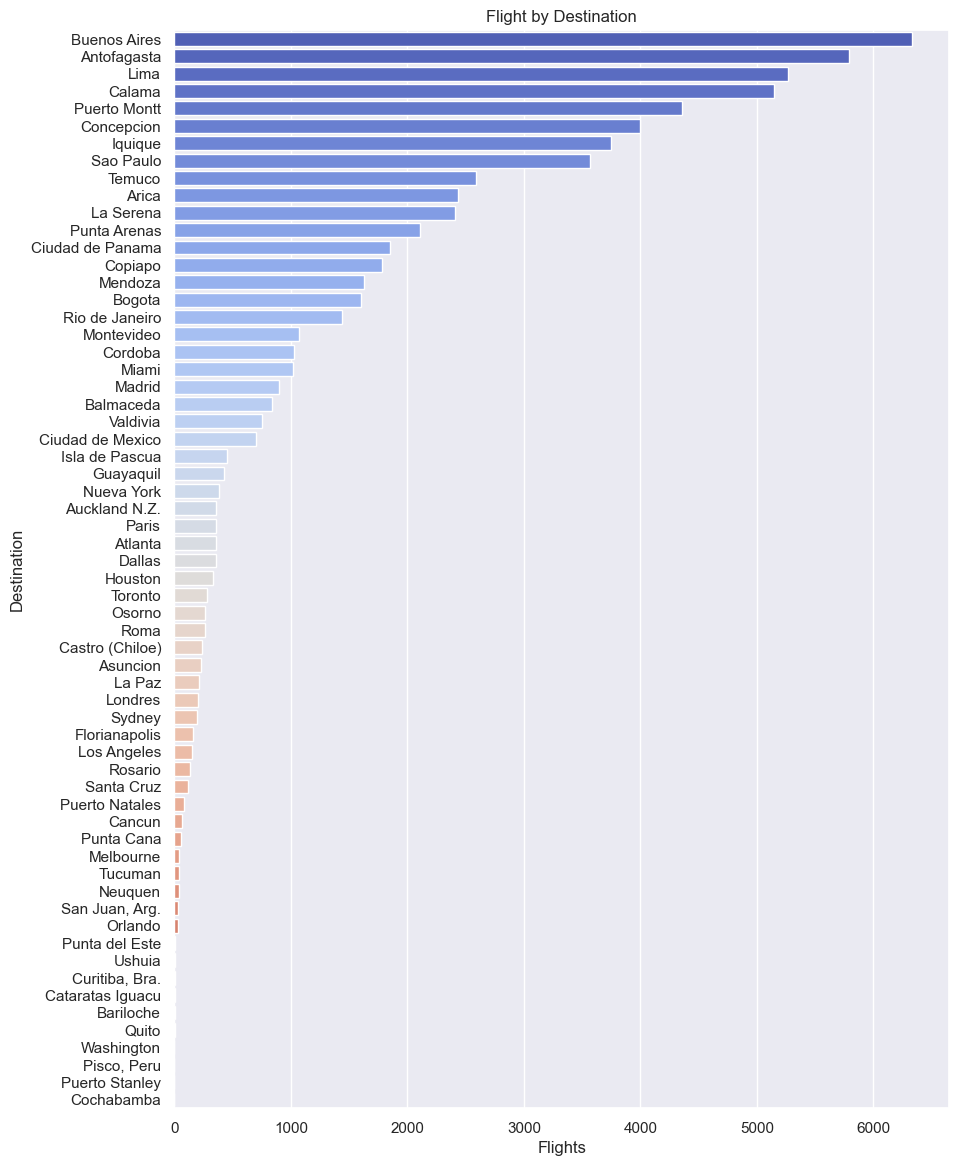

In [157]:
flight_by_destination = data['SIGLADES'].value_counts()

# Create a gradient palette
palette = sns.color_palette("coolwarm", len(flight_by_destination))

plt.figure(figsize = (10, 14))
sns.barplot(y=flight_by_destination.index, x=flight_by_destination.values, palette=palette, alpha=1)
plt.title('Flight by Destination')
plt.xlabel('Flights')
plt.ylabel('Destination')
plt.show()

## 2. Features Generation

### 2.a. Period of Day

In [187]:
from datetime import datetime, time

def get_period_day(date: str) -> str:
    """
    Determine the period of the day (mañana, tarde, noche) based on the provided datetime string.

    Parameters
    ----------
    date : str
        A string representing the date and time in the format '%Y-%m-%d %H:%M:%S'.

    Returns
    -------
    str
        The period of the day:
        - 'mañana' (morning): 05:00 - 11:59
        - 'tarde' (afternoon): 12:00 - 18:59
        - 'noche' (night): 19:00 - 04:59
        If the date format is invalid, returns 'Invalid date format'.
    """
    try:
        date_time = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
        time_of_day = date_time.time()
        
        if time(5, 0) <= time_of_day < time(12, 0):
            return 'mañana'
        elif time(12, 0) <= time_of_day < time(19, 0):
            return 'tarde'
        else:
            return 'noche'
    except ValueError:
        return 'Invalid date format'

In [188]:
data['period_day'] = data['Fecha-I'].apply(get_period_day)

### 2.b. High Season

In [189]:
from datetime import datetime

def is_high_season(fecha: str) -> int:
    """
    Determine if a given date falls within the high season periods.

    Parameters
    ----------
    fecha : str
        A string representing the date and time in the format '%Y-%m-%d %H:%M:%S'.

    Returns
    -------
    int
        1 if the date falls within the high season, 0 otherwise.

    High Season Periods
    -------------------
    - 15-Dec to 31-Dec
    - 1-Jan to 3-Mar
    - 15-Jul to 31-Jul
    - 11-Sep to 30-Sep
    """
    try:
        date_time = datetime.strptime(fecha, '%Y-%m-%d %H:%M:%S')
        year = date_time.year

        high_season_ranges = [
            (datetime(year, 12, 15), datetime(year, 12, 31)),
            (datetime(year, 1, 1), datetime(year, 3, 3)),
            (datetime(year, 7, 15), datetime(year, 7, 31)),
            (datetime(year, 9, 11), datetime(year, 9, 30))
        ]

        for start, end in high_season_ranges:
            if start <= date_time <= end:
                return 1
        return 0
    except ValueError:
        return 0  # or handle the invalid date format as needed

In [190]:
data['high_season'] = data['Fecha-I'].apply(is_high_season)

### 2.c. Difference in Minutes

In [192]:
def get_min_diff(data: Dict[str, str]) -> float:
    """
    Calculate the difference in minutes between two datetime strings in a dictionary.

    Parameters
    ----------
    data : dict
        A dictionary containing two keys:
        - 'Fecha-O': str, a datetime string in the format '%Y-%m-%d %H:%M:%S'
        - 'Fecha-I': str, a datetime string in the format '%Y-%m-%d %H:%M:%S'

    Returns
    -------
    float
        The difference in minutes between 'Fecha-O' and 'Fecha-I'.
    """
    try:
        fecha_o = datetime.strptime(data['Fecha-O'], '%Y-%m-%d %H:%M:%S')
        fecha_i = datetime.strptime(data['Fecha-I'], '%Y-%m-%d %H:%M:%S')
        min_diff = (fecha_o - fecha_i).total_seconds() / 60
        return min_diff
    except (ValueError, KeyError) as e:
        raise ValueError("Invalid input data or date format") from e

In [193]:
data['min_diff'] = data.apply(get_min_diff, axis = 1)

### 2.d. Delay

In [138]:
threshold_in_minutes = 15
data['delay'] = np.where(data['min_diff'] > threshold_in_minutes, 1, 0)

In [139]:
data.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'period_day', 'high_season',
       'min_diff', 'delay'],
      dtype='object')

## 3. Data Analysis: Second Sight

### How is the delay rate across columns?

In [223]:
def get_rate_from_column(data: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Calculate the inverse rate of delays for each unique value in a specified column.

    Parameters
    ----------
    data : pd.DataFrame
        The input DataFrame containing the data.
    column : str
        The name of the column to calculate rates for.

    Returns
    -------
    pd.DataFrame
        A DataFrame with the calculated inverse rates for each unique value in the specified column.

    Notes
    -----
    The rate is calculated as (total occurrences) / (delay occurrences).
    If there are no delays for a value, the rate is set to 0.
    This is an inverse rate, where higher values indicate fewer delays relative to total occurrences.
    """
    # Count delays for each unique value in the column
    delays = data[data['delay'] == 1][column].value_counts()

    # Count total occurrences for each unique value in the column
    totals = data[column].value_counts()

    # Calculate rates
    rates = {}
    for name in totals.index:
        if name in delays.index and delays[name] != 0:
            rates[name] = round(delays[name] / totals[name], 2) * 100
        else:
            rates[name] = 0

    return pd.DataFrame.from_dict(data=rates, orient='index', columns=['Tasa (%)'])

In [224]:
get_rate_from_column(data, 'SIGLADES')['Tasa (%)'].sort_values(ascending=False)

Cochabamba          100.0
Puerto Stanley      100.0
Quito               100.0
Ushuia               67.0
Sydney               58.0
                    ...  
Houston               5.0
Curitiba, Bra.        0.0
Cataratas Iguacu      0.0
Washington            0.0
Pisco, Peru           0.0
Name: Tasa (%), Length: 62, dtype: float64

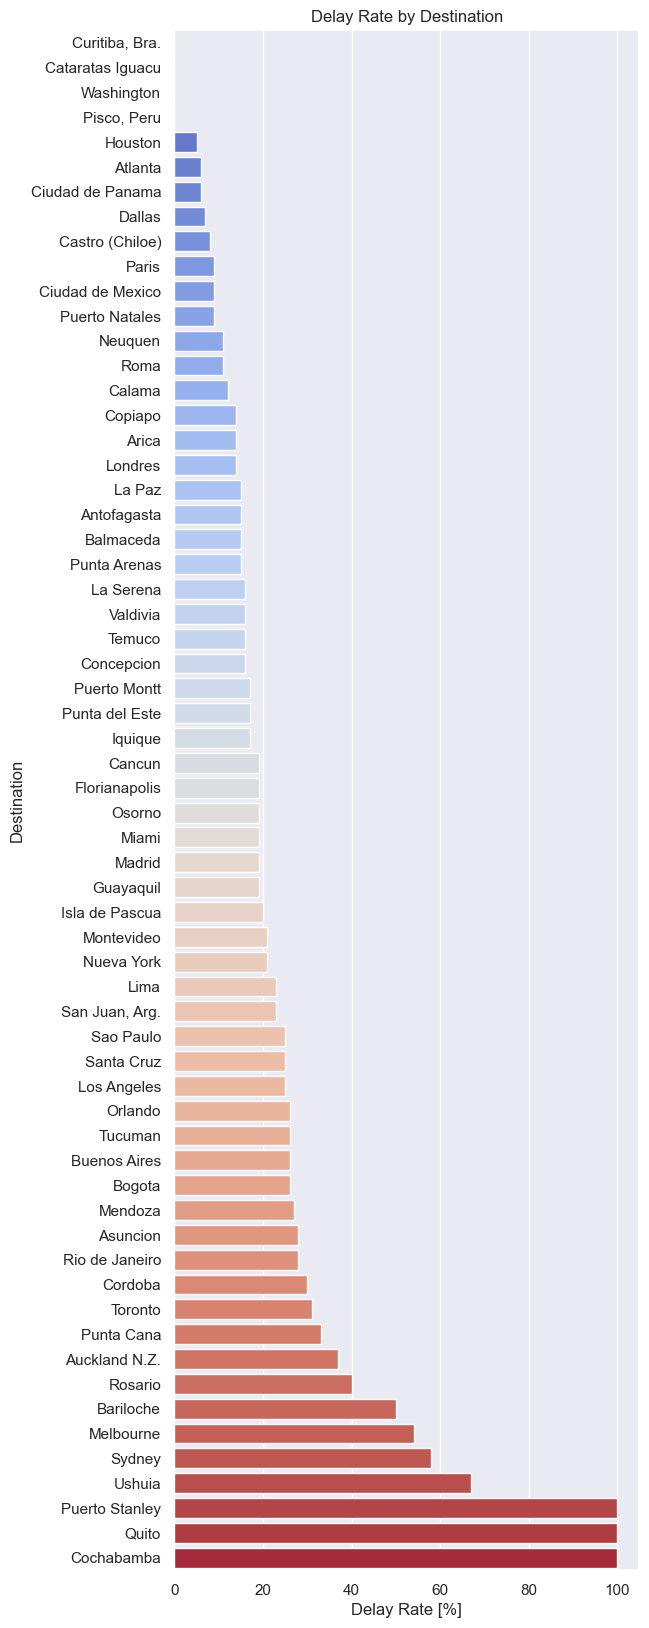

In [225]:
destination_rate = get_rate_from_column(data, 'SIGLADES')
destination_rate_tasa = destination_rate['Tasa (%)']
destination_rate_tasa = destination_rate_tasa.sort_values(ascending=True)

plt.figure(figsize = (6,20))
# Create a gradient palette
palette = sns.color_palette("coolwarm", len(destination_rate_tasa))

sns.barplot(y=destination_rate_tasa.index, x=destination_rate_tasa.values, palette=palette, alpha = 1)
plt.title('Delay Rate by Destination')
plt.xlabel('Delay Rate [%]')
plt.ylabel('Destination')
plt.xticks()
plt.show()

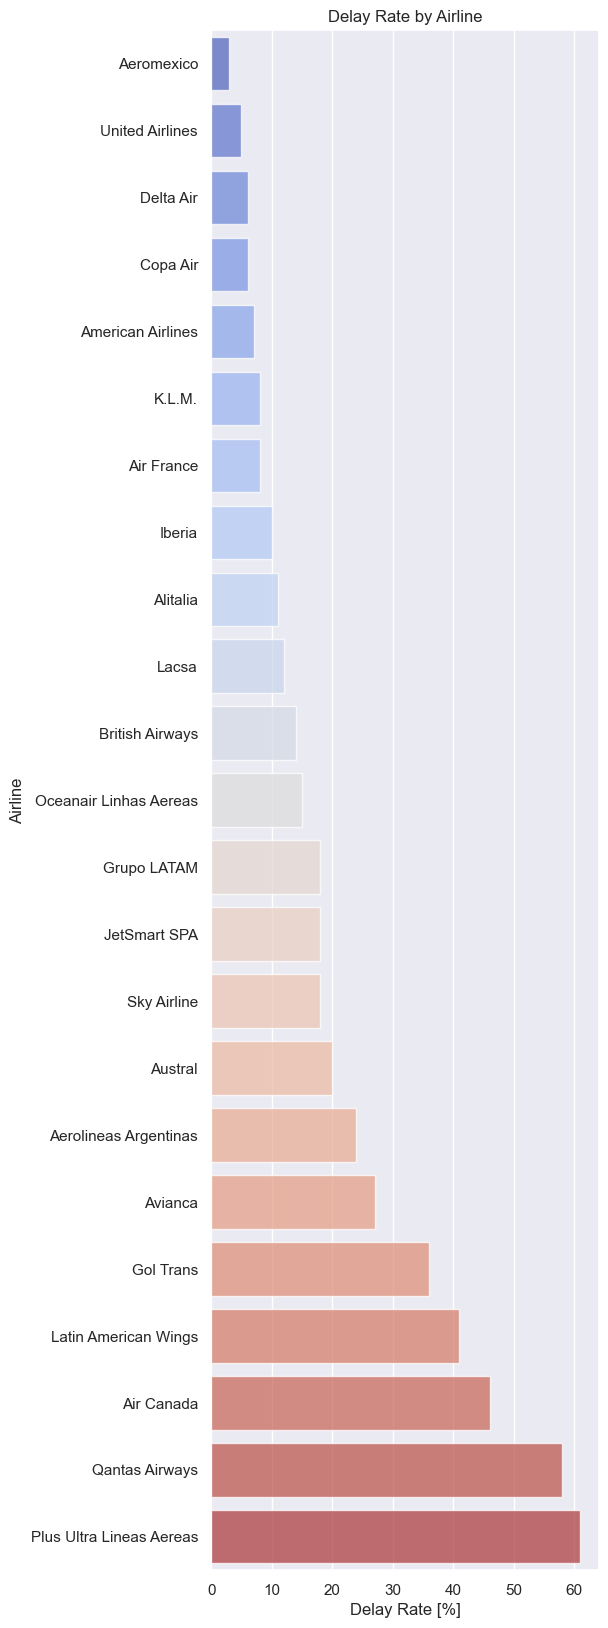

In [227]:
airlines_rate = get_rate_from_column(data, 'OPERA')
airlines_rate_tasa = airlines_rate['Tasa (%)']
airlines_rate_tasa = airlines_rate_tasa.sort_values()

# Create a gradient palette
palette = sns.color_palette("coolwarm", len(airlines_rate_tasa))

plt.figure(figsize = (5,20))

sns.barplot(y=airlines_rate_tasa.index, x=airlines_rate_tasa.values, palette=palette, alpha = 0.75)
plt.title('Delay Rate by Airline')
plt.xlabel('Delay Rate [%]')
plt.ylabel('Airline')
plt.xticks()
plt.show()

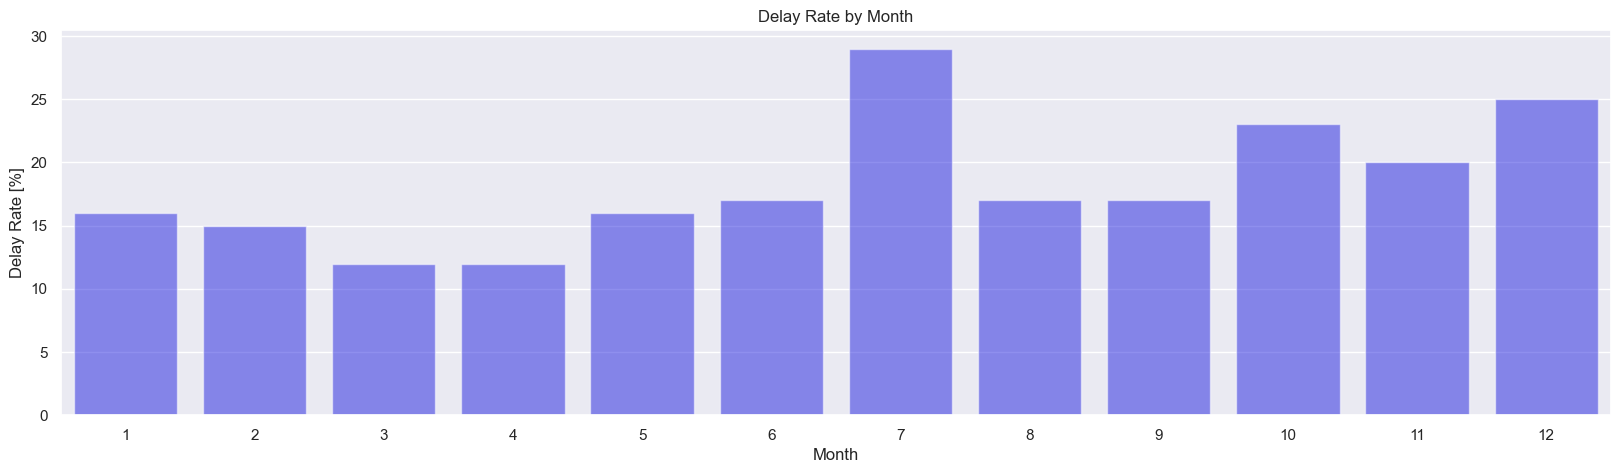

In [258]:
month_rate = get_rate_from_column(data, 'MES')
month_rate_value = data['MES'].value_counts().index
plt.figure(figsize = (20,5))

sns.barplot(x=month_rate_value, y=month_rate['Tasa (%)'], color = 'blue', alpha = 0.5)
plt.title('Delay Rate by Month')
plt.ylabel('Delay Rate [%]')
plt.xlabel('Month')
plt.xticks()
plt.show()

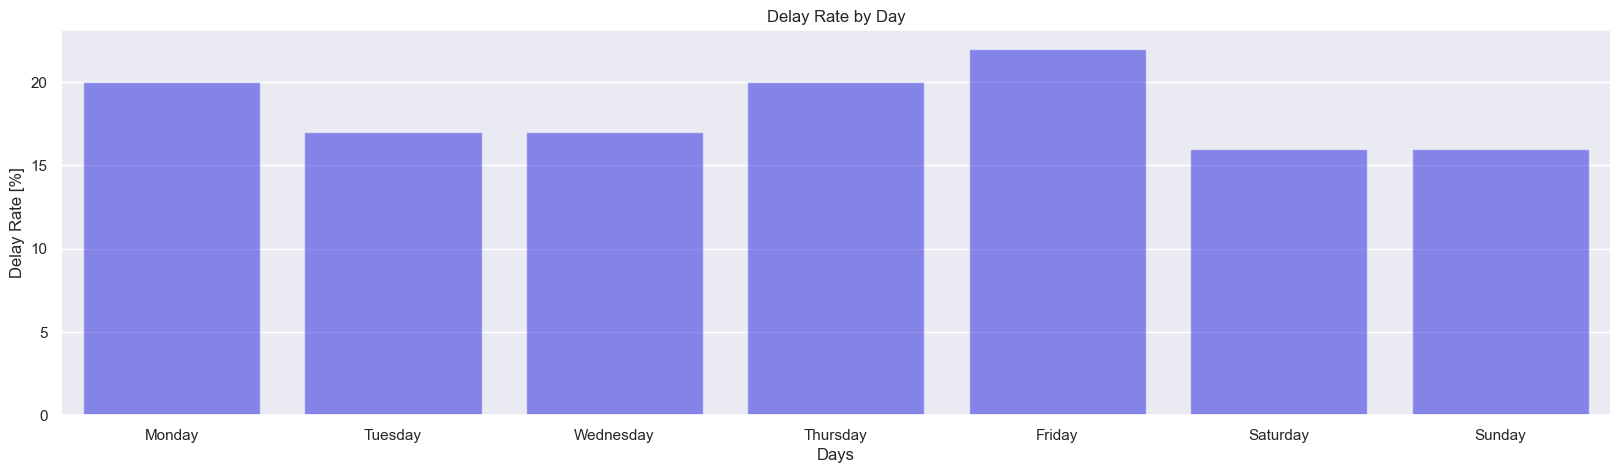

In [259]:
days_rate = get_rate_from_column(data, 'DIANOM')
days_rate_tasa = days_rate['Tasa (%)']

# Define the order and translation of the days
days_translation = {
    'Lunes': 'Monday',
    'Martes': 'Tuesday',
    'Miercoles': 'Wednesday',
    'Jueves': 'Thursday',
    'Viernes': 'Friday',
    'Sabado': 'Saturday',
    'Domingo': 'Sunday'
}

# Reindex the DataFrame
days_rate_tasa = days_rate_tasa.reindex(days_translation.keys())

# Translate the index
days_rate_tasa.index = days_rate_tasa.index.map(days_translation)

plt.figure(figsize = (20, 5))
sns.barplot(x=days_rate_tasa.index, y=days_rate_tasa.values, color = 'blue', alpha = 0.5)
plt.title('Delay Rate by Day')
plt.ylabel('Delay Rate [%]')
plt.xlabel('Days')
plt.xticks()
plt.show()

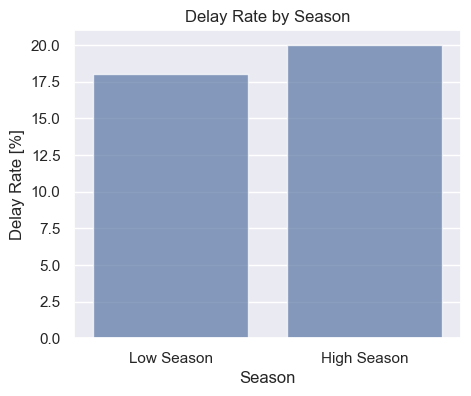

In [262]:
high_season_rate = get_rate_from_column(data, 'high_season')
high_season_rate_values = data['high_season'].value_counts().index

plt.figure(figsize = (5, 4))

sns.barplot(x=["Low Season", "High Season"], y=high_season_rate['Tasa (%)'], alpha=0.7)
plt.title('Delay Rate by Season')
plt.ylabel('Delay Rate [%]')
plt.xlabel('Season')
plt.xticks()
plt.show()

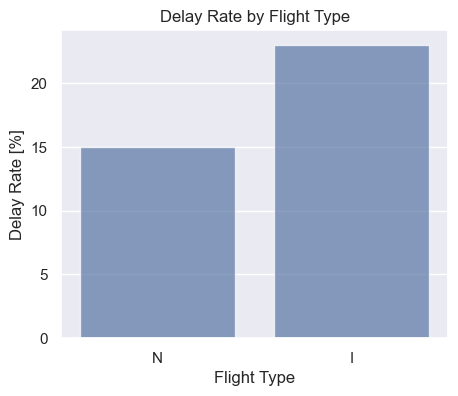

In [264]:
flight_type_rate = get_rate_from_column(data, 'TIPOVUELO')
flight_type_rate_values = data['TIPOVUELO'].value_counts().index
plt.figure(figsize = (5, 4))

sns.barplot(x=flight_type_rate_values,y=flight_type_rate['Tasa (%)'], alpha=0.7)
plt.title('Delay Rate by Flight Type')
plt.ylabel('Delay Rate [%]')
plt.xlabel('Flight Type')
plt.show()

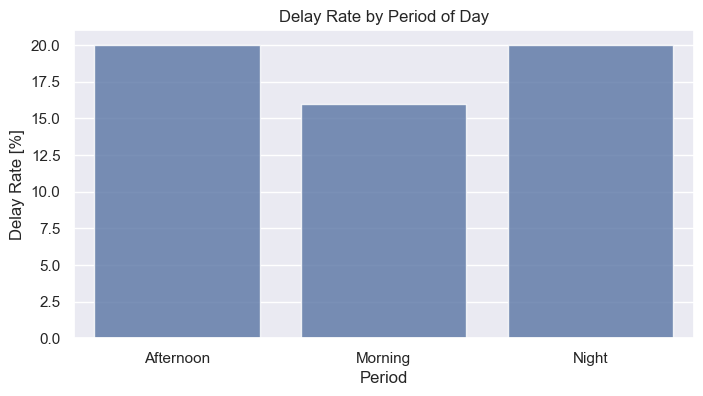

In [268]:
period_day_rate = get_rate_from_column(data, 'period_day')
period_day_rate_tasa = period_day_rate['Tasa (%)']

# Mapping Spanish labels to English
label_map = {'tarde': 'Afternoon', 'mañana': 'Morning', 'noche': 'Night'}
translated_labels = [label_map[label] for label in period_day_rate_tasa.index]

plt.figure(figsize = (8, 4))

sns.barplot(x=translated_labels, y=period_day_rate_tasa.values, alpha=0.8)
plt.title('Delay Rate by Period of Day')
plt.ylabel('Delay Rate [%]')
plt.xlabel('Period')
plt.show()

## 4. Training

### 4.a. Data Split (Training and Validation)

In [236]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

In [237]:
training_data = shuffle(data[['OPERA', 'MES', 'TIPOVUELO', 'SIGLADES', 'DIANOM', 'delay']], random_state = 111)

In [238]:
features = pd.concat([
    pd.get_dummies(data['OPERA'], prefix = 'OPERA'),
    pd.get_dummies(data['TIPOVUELO'], prefix = 'TIPOVUELO'), 
    pd.get_dummies(data['MES'], prefix = 'MES')], 
    axis = 1
)
target = data['delay']

In [239]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.33, random_state = 42)

In [240]:
print(f"train shape: {x_train.shape} | test shape: {x_test.shape}")

train shape: (45698, 37) | test shape: (22508, 37)


In [241]:
y_train.value_counts('%')*100

delay
0    81.618452
1    18.381548
Name: proportion, dtype: float64

In [242]:
y_test.value_counts('%')*100

delay
0    81.277768
1    18.722232
Name: proportion, dtype: float64

### 4.b. Model Selection

#### 4.b.i. XGBoost

In [243]:
import xgboost as xgb
from xgboost import plot_importance

In [244]:
xgb_model = xgb.XGBClassifier(random_state=1, learning_rate=0.01)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [245]:
xgboost_y_preds = xgb_model.predict(x_test)
xgboost_y_preds = [1 if y_pred > 0.5 else 0 for y_pred in xgboost_y_preds]

In [246]:
confusion_matrix(y_test, xgboost_y_preds)

array([[18294,     0],
       [ 4214,     0]])

In [247]:
print(classification_report(y_test, xgboost_y_preds))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     18294
           1       0.00      0.00      0.00      4214

    accuracy                           0.81     22508
   macro avg       0.41      0.50      0.45     22508
weighted avg       0.66      0.81      0.73     22508



#### 4.b.ii. Logistic Regression

In [248]:
from sklearn.linear_model import LogisticRegression

In [249]:
reg_model = LogisticRegression()
reg_model.fit(x_train, y_train)

LogisticRegression()

In [250]:
reg_y_preds = reg_model.predict(x_test)

In [251]:
confusion_matrix(y_test, reg_y_preds)

array([[18193,   101],
       [ 4086,   128]])

In [255]:
print(classification_report(y_test, reg_y_preds))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     18294
           1       0.56      0.03      0.06      4214

    accuracy                           0.81     22508
   macro avg       0.69      0.51      0.48     22508
weighted avg       0.77      0.81      0.74     22508



## 5. Data Analysis: Third Sight

### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1000x500 with 0 Axes>

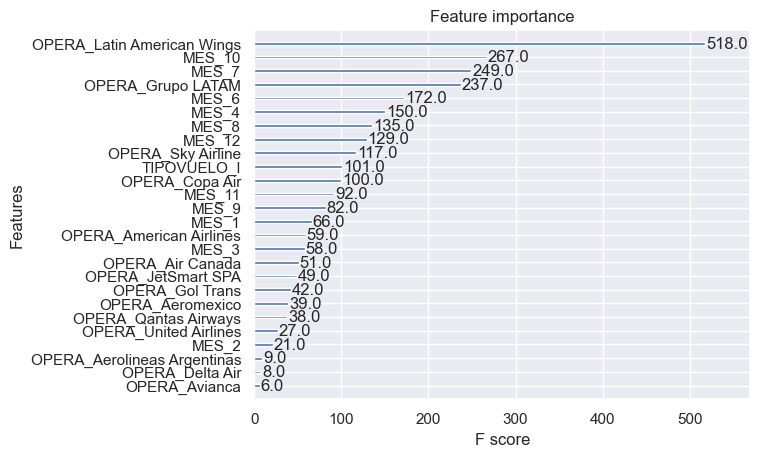

In [253]:
plt.figure(figsize = (10,5))
plot_importance(xgb_model)

In [44]:
top_10_features = [
    "OPERA_Latin American Wings", 
    "MES_7",
    "MES_10",
    "OPERA_Grupo LATAM",
    "MES_12",
    "TIPOVUELO_I",
    "MES_4",
    "MES_11",
    "OPERA_Sky Airline",
    "OPERA_Copa Air"
]

### Data Balance

In [45]:
n_y0 = len(y_train[y_train == 0])
n_y1 = len(y_train[y_train == 1])
scale = n_y0/n_y1
print(scale)

4.4402380952380955


## 6. Training with Improvement

### 6.a. Data Split

In [46]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(features[top_10_features], target, test_size = 0.33, random_state = 42)

### 6.b. Model Selection

#### 6.b.i. XGBoost with Feature Importance and with Balance

In [47]:
xgb_model_2 = xgb.XGBClassifier(random_state=1, learning_rate=0.01, scale_pos_weight = scale)
xgb_model_2.fit(x_train2, y_train2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [48]:
xgboost_y_preds_2 = xgb_model_2.predict(x_test2)

In [49]:
confusion_matrix(y_test2, xgboost_y_preds_2)

array([[9556, 8738],
       [1313, 2901]])

In [50]:
print(classification_report(y_test2, xgboost_y_preds_2))

              precision    recall  f1-score   support

           0       0.88      0.52      0.66     18294
           1       0.25      0.69      0.37      4214

    accuracy                           0.55     22508
   macro avg       0.56      0.61      0.51     22508
weighted avg       0.76      0.55      0.60     22508



#### 6.b.ii. XGBoost with Feature Importance but without Balance

In [51]:
xgb_model_3 = xgb.XGBClassifier(random_state=1, learning_rate=0.01)
xgb_model_3.fit(x_train2, y_train2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [52]:
xgboost_y_preds_3 = xgb_model_3.predict(x_test2)

In [53]:
confusion_matrix(y_test2, xgboost_y_preds_3)

array([[18286,     8],
       [ 4188,    26]])

In [54]:
print(classification_report(y_test2, xgboost_y_preds_3))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     18294
           1       0.76      0.01      0.01      4214

    accuracy                           0.81     22508
   macro avg       0.79      0.50      0.45     22508
weighted avg       0.80      0.81      0.73     22508



#### 6.b.iii. Logistic Regression with Feature Importante and with Balance

In [55]:
reg_model_2 = LogisticRegression(class_weight={1: n_y0/len(y_train), 0: n_y1/len(y_train)})
reg_model_2.fit(x_train2, y_train2)

LogisticRegression(class_weight={0: 0.18381548426626987, 1: 0.8161845157337302})

In [56]:
reg_y_preds_2 = reg_model_2.predict(x_test2)

In [57]:
confusion_matrix(y_test2, reg_y_preds_2)

array([[9487, 8807],
       [1314, 2900]])

In [58]:
print(classification_report(y_test2, reg_y_preds_2))

              precision    recall  f1-score   support

           0       0.88      0.52      0.65     18294
           1       0.25      0.69      0.36      4214

    accuracy                           0.55     22508
   macro avg       0.56      0.60      0.51     22508
weighted avg       0.76      0.55      0.60     22508



#### 6.b.iv. Logistic Regression with Feature Importante but without Balance

In [59]:
reg_model_3 = LogisticRegression()
reg_model_3.fit(x_train2, y_train2)

LogisticRegression()

In [60]:
reg_y_preds_3 = reg_model_3.predict(x_test2)

In [61]:
confusion_matrix(y_test2, reg_y_preds_3)

array([[18246,    48],
       [ 4160,    54]])

In [62]:
print(classification_report(y_test2, reg_y_preds_3))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     18294
           1       0.53      0.01      0.03      4214

    accuracy                           0.81     22508
   macro avg       0.67      0.51      0.46     22508
weighted avg       0.76      0.81      0.73     22508



## 7. Data Science Conclusions

By looking at the results of the 6 trained models, it can be determined:
- There is no noticeable difference in results between XGBoost and LogisticRegression.
- Does not decrease the performance of the model by reducing the features to the 10 most important.
- Improves the model's performance when balancing classes, since it increases the recall of class "1".

**With this, the model to be productive must be the one that is trained with the top 10 features and class balancing, but which one?**